In [1]:
import xarray as xr
import cftime
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
plt.rcParams['figure.figsize'] = [12,8]
plt.rc('font', size=15)
plt.rc('axes', titlesize=15)

In [3]:
def monthly_to_annual(array):
    """ calculate annual mena from monthly data, using unequal month lengths fros noleap calendar.  
    originally written by Keith Lindsay."""
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

def savgol_filter(array, window, order=2):
    smooth_array = array.copy()
    smooth_array[:] = scipy.signal.savgol_filter(array, window, order)
    return(smooth_array)


In [4]:
datadir = '/glade/scratch/charlie/archive/cesm_edriven_idealizedcdr_feb2022_v3'

lnd_in = xr.open_dataset(datadir+'/lnd/hist/cesm_edriven_idealizedcdr_feb2022_v3.clm2.sofar.nc')
ocn_in = xr.open_dataset(datadir+'/ocn/hist/cesm_edriven_idealizedcdr_feb2022_v3.pop.sofar.nc', decode_times=False)
atm_in = xr.open_dataset(datadir+'/atm/hist/cesm_edriven_idealizedcdr_feb2022_v3.cam.sofar.nc')

areacella = xr.open_dataset('/glade/scratch/charlie/cmip/areacella_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')
areacello = xr.open_dataset('/glade/scratch/charlie/cmip/areacello_Ofx_CESM2_1pctCO2_r1i1p1f1_gn.nc')

sftlf = xr.open_dataset('/glade/scratch/charlie/cmip/sftlf_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')
sftgif = xr.open_dataset('/glade/scratch/charlie/cmip/sftgif_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')



/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding 

In [5]:
nyears = len(lnd_in['time'])/12.
print(nyears)

350.0


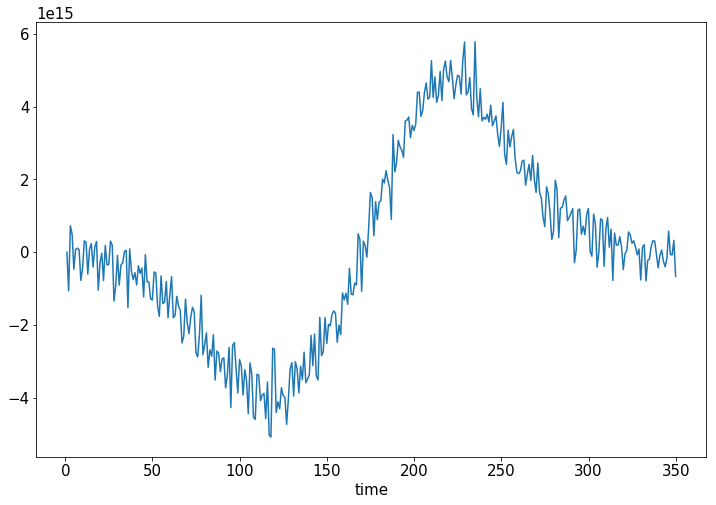

In [6]:
nbp_global = (lnd_in['NEE'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
nbp_global['time'] = np.arange(len(nbp_global['time']))/12.
nbp_annual = (monthly_to_annual(nbp_global)*86400. * 365.)
#nbp_annual.cumsum().plot()
nbp_annual.plot()

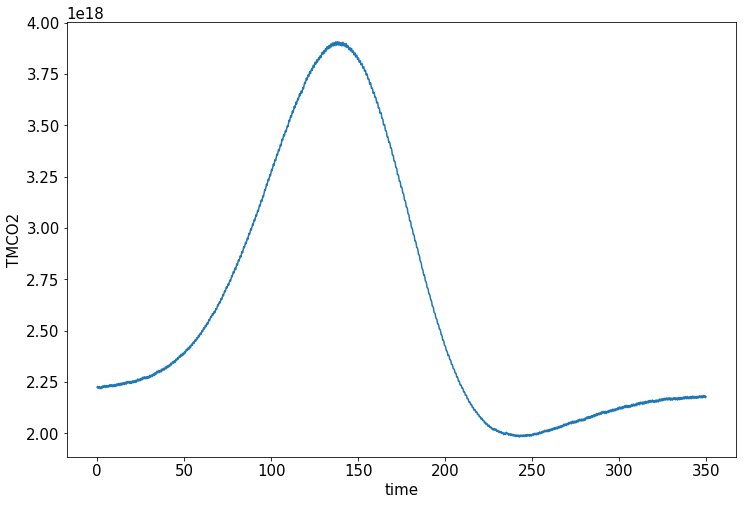

In [7]:
atmco2burden = (atm_in['TMCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) * 1e3
atmco2burden['time'] = np.arange(len(atmco2burden['time']))/12.
atmco2burden.plot()

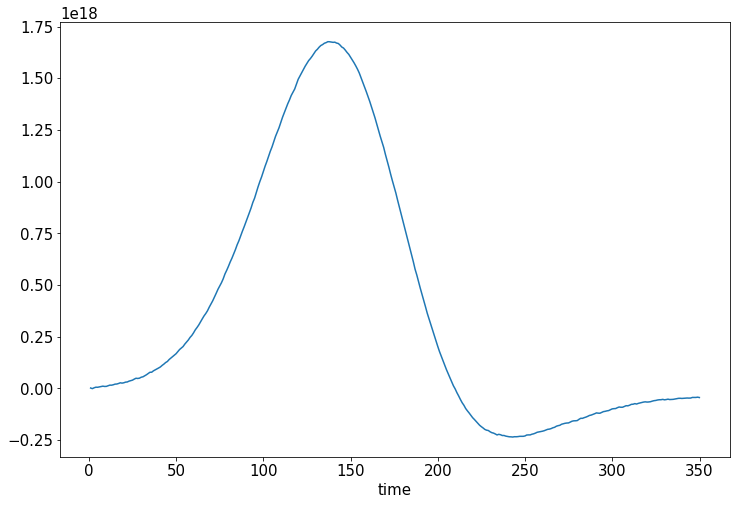

In [8]:
sfco2 = (atm_in['SFCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))
sfco2['time'] = np.arange(len(sfco2['time']))/12.
sfco2_annual = monthly_to_annual(sfco2) * 86400. * 365. * 1e3 
sfco2_annual.cumsum().plot()

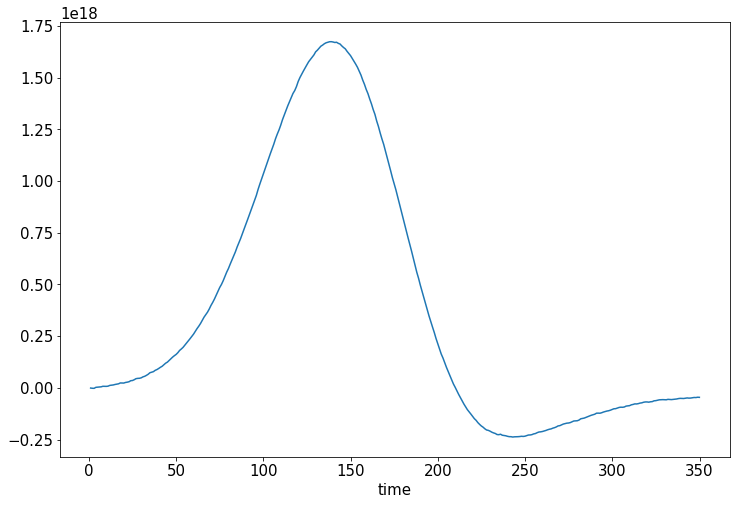

In [9]:
annual_atm_accum = monthly_to_annual(atmco2burden- atmco2burden[0])
annual_atm_accum.plot()

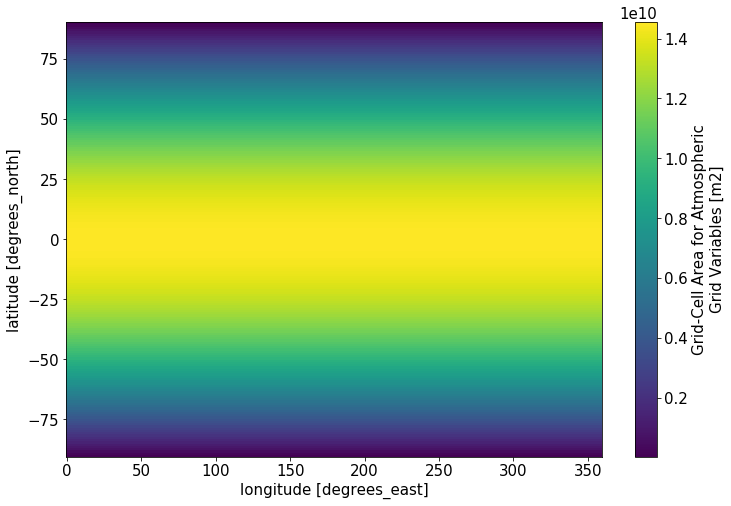

In [10]:
areacella['areacella'].plot()

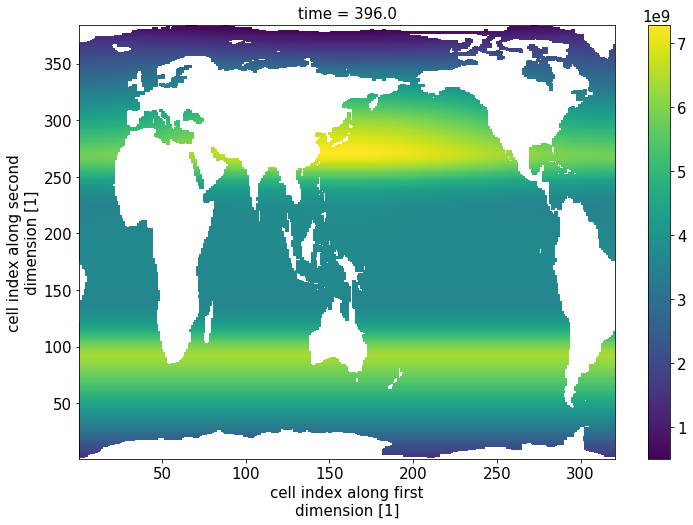

In [11]:
ocnmask = 1. * (ocn_in['SSH'].isel(time=0))/(ocn_in['SSH'].isel(time=0))
(areacello['areacello'] * ocnmask).plot()

/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


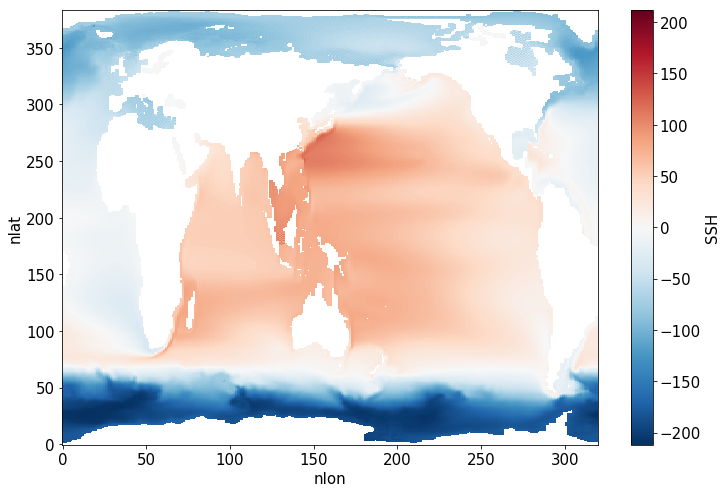

In [12]:
ocn_in['SSH'].mean(dim='time').plot()

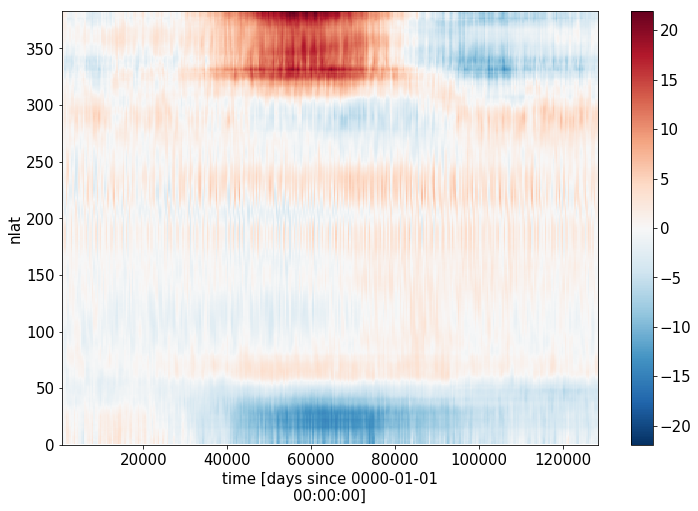

In [13]:
monthly_to_annual(ocn_in['SSH'].mean(dim='nlon') - ocn_in['SSH'].mean(dim='nlon').isel(time=slice(0,20)).mean(dim='time')).plot(y='nlat',x='time')

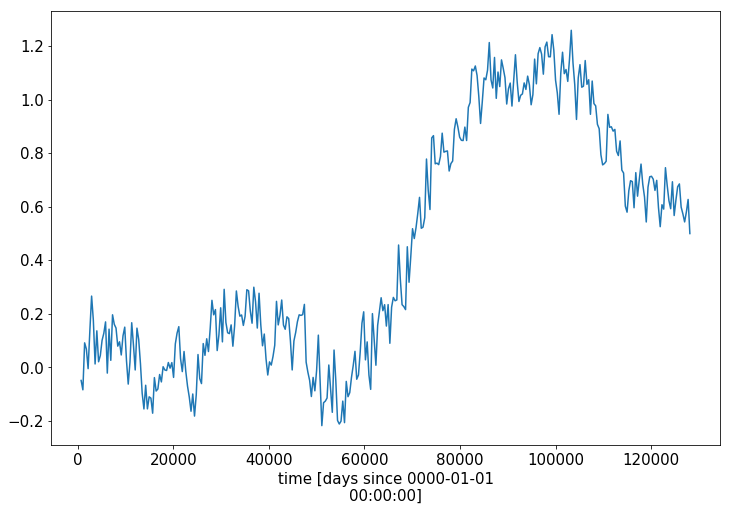

In [14]:
monthly_to_annual(ocn_in['SSH'].isel(nlat=slice(50,300)).mean(dim=('nlon','nlat')) - ocn_in['SSH'].isel(nlat=slice(50,300)).mean(dim=('nlon','nlat')).isel(time=slice(0,20)).mean(dim='time')).plot()

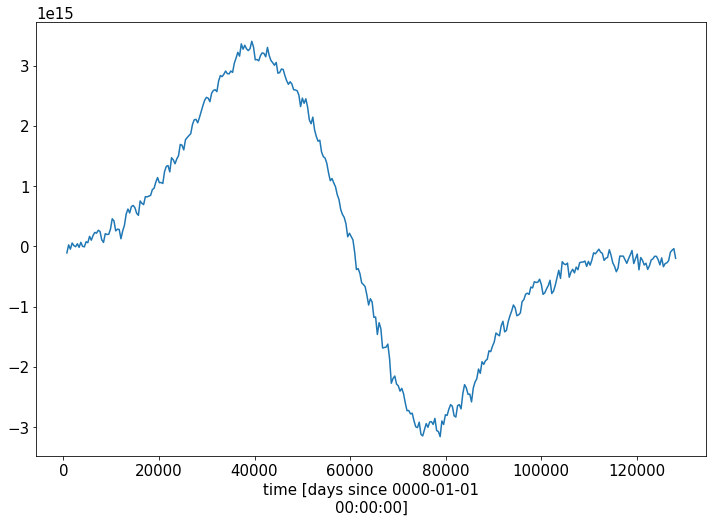

In [15]:
fgco2_global = (ocn_in['FG_CO2'] * areacello['areacello'].data * 12.0e-8 * 86400. * 365. * 1e3).sum(dim=('nlat', 'nlon'))
fgco2_global_annual = monthly_to_annual(fgco2_global)
fgco2_global_annual.plot()


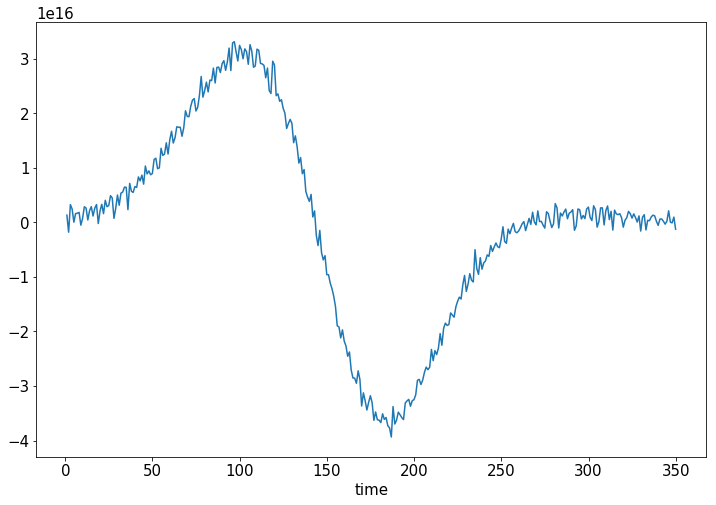

In [16]:
(fgco2_global_annual.data - nbp_annual.data + sfco2_annual).plot()

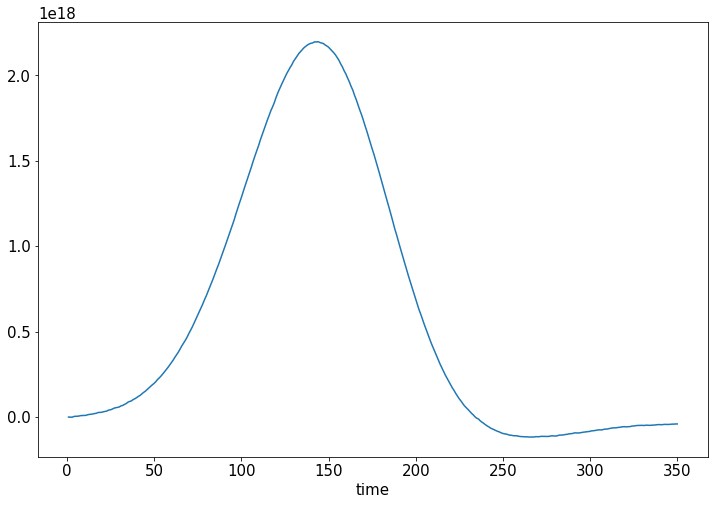

In [17]:
(fgco2_global_annual.cumsum().data - nbp_annual.cumsum().data + annual_atm_accum).plot()

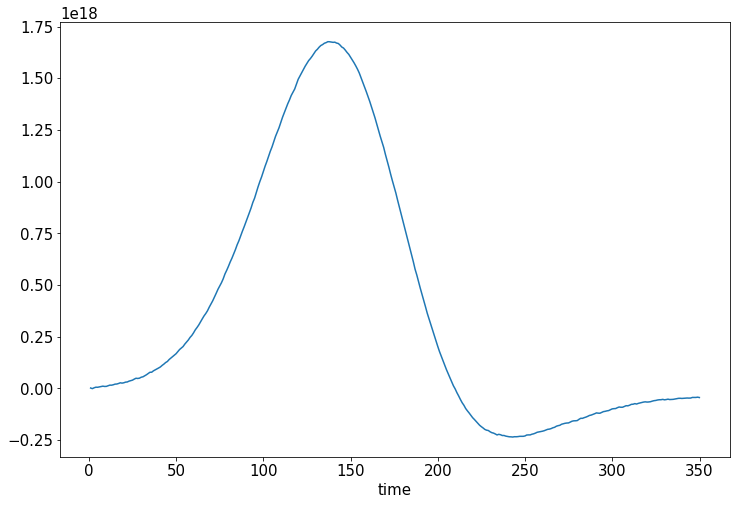

In [18]:
sfco2 = (atm_in['SFCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))
sfco2['time'] = np.arange(len(sfco2['time']))/12.
sfco2_annual = monthly_to_annual(sfco2) * 86400. * 365. * 1e3 
sfco2_annual.cumsum().plot()

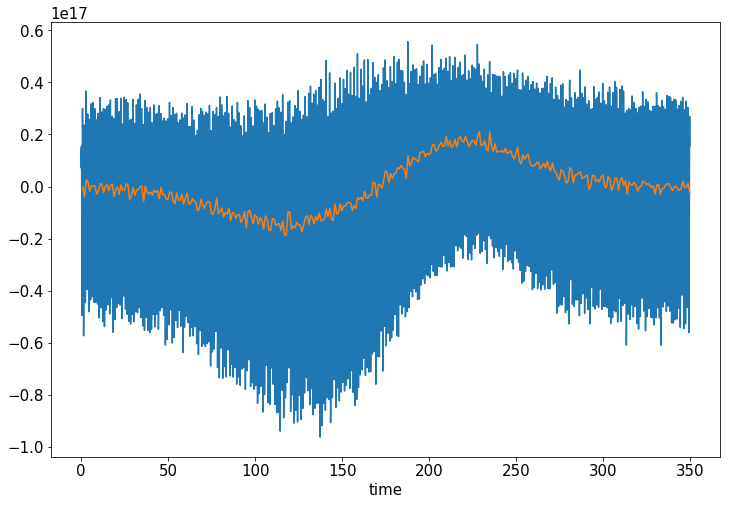

In [19]:
sfco2_lnd = (atm_in['SFCO2_LND'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))* 86400. * 365. * 1e3 
sfco2_lnd['time'] = np.arange(len(sfco2_lnd['time']))/12.
sfco2_lnd_annual = monthly_to_annual(sfco2_lnd) 
sfco2_lnd.plot()
sfco2_lnd_annual.plot()

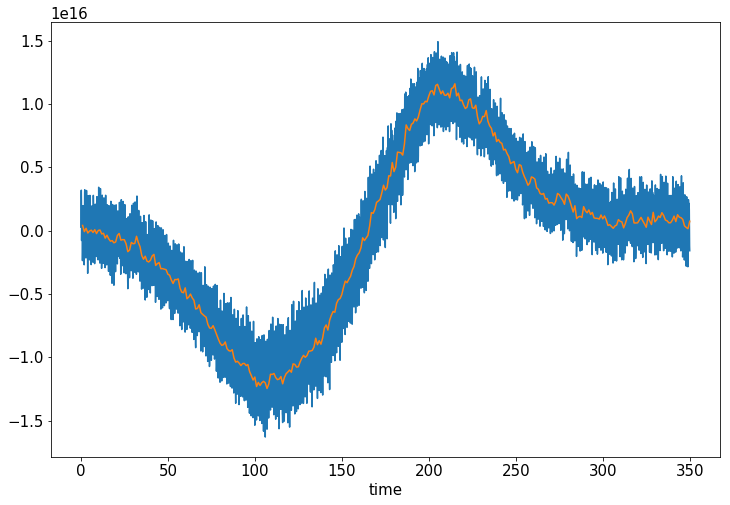

In [20]:
sfco2_ocn = (atm_in['SFCO2_OCN'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))* 86400. * 365. * 1e3 
sfco2_ocn['time'] = np.arange(len(sfco2_ocn['time']))/12.
sfco2_ocn_annual = monthly_to_annual(sfco2_ocn) 
sfco2_ocn.plot()
sfco2_ocn_annual.plot()

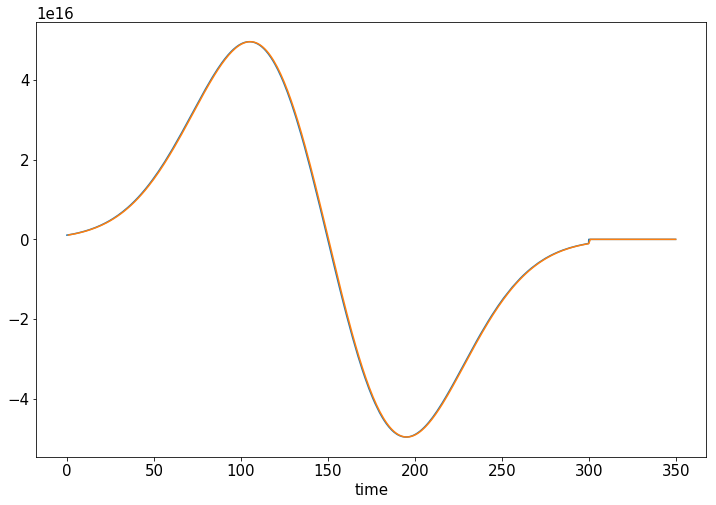

In [21]:
sfco2_fff = (atm_in['SFCO2_FFF'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))* 86400. * 365. * 1e3 
sfco2_fff['time'] = np.arange(len(sfco2_fff['time']))/12.
sfco2_fff_annual = monthly_to_annual(sfco2_fff) 
sfco2_fff.plot()
sfco2_fff_annual.plot()

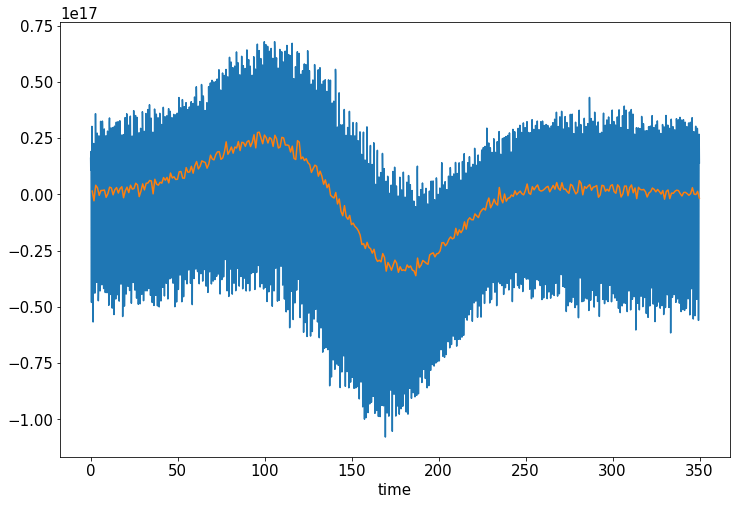

In [22]:
sfco2_tot = (atm_in['SFCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))* 86400. * 365. * 1e3 
sfco2_tot['time'] = np.arange(len(sfco2_tot['time']))/12.
sfco2_tot_annual = monthly_to_annual(sfco2_tot) 
sfco2_tot.plot()
sfco2_tot_annual.plot()

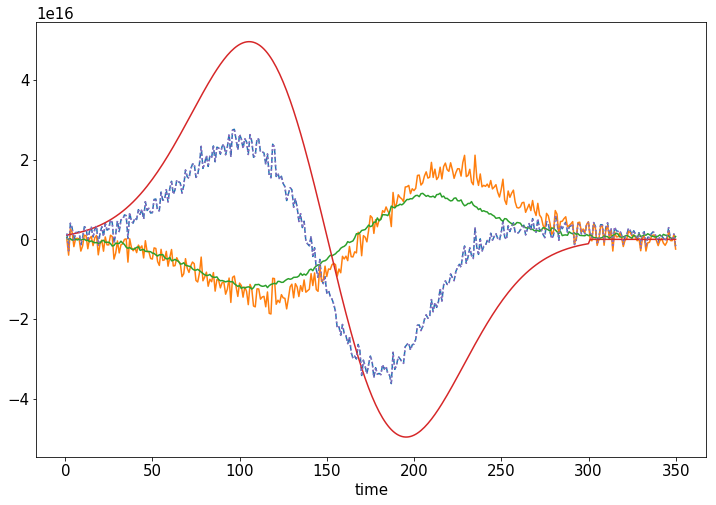

In [23]:
sfco2_tot_annual.plot(linestyle='--')
sfco2_lnd_annual.plot()
sfco2_ocn_annual.plot()
sfco2_fff_annual.plot()
(sfco2_lnd_annual + sfco2_ocn_annual + sfco2_fff_annual).plot(linestyle='dotted')

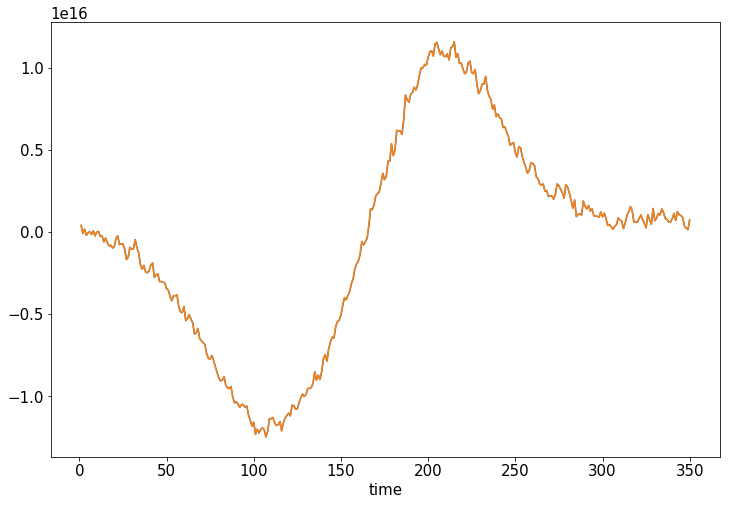

In [24]:
fgco2_global_annual['time'] = np.arange(len(fgco2_global_annual['time']))+1.
(0.-fgco2_global_annual * 44./12.).plot()
sfco2_ocn_annual.plot()

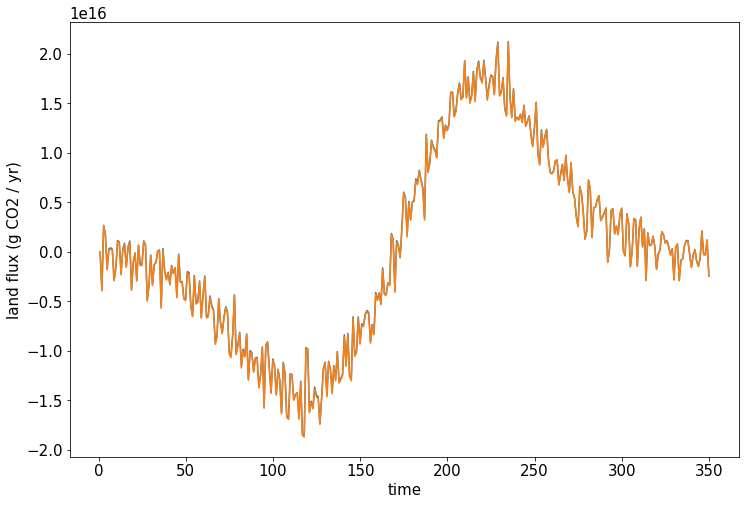

In [25]:
(nbp_annual*44./12.).plot()
sfco2_lnd_annual.attrs['long_name'] = 'land flux (g CO2 / yr)'
sfco2_lnd_annual.plot()


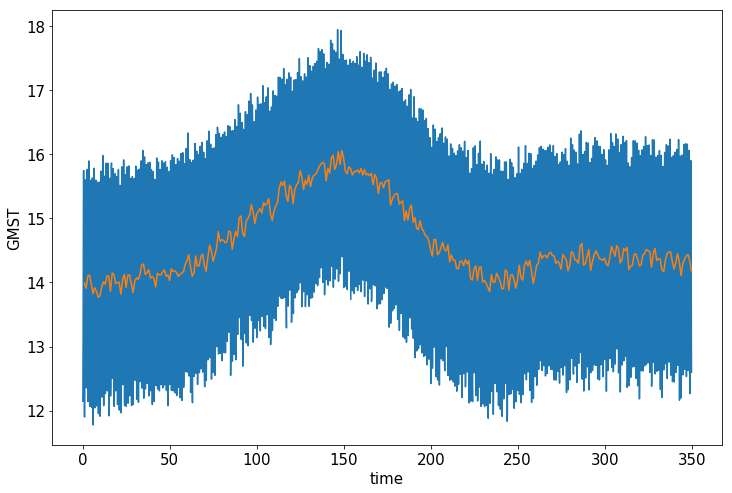

In [26]:
gmst =  -273.15 +(atm_in['TREFHT'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
gmst['time'] = np.arange(len(gmst['time']))/12.
gmst_annual = monthly_to_annual(gmst)
gmst_annual.attrs['long_name'] = 'GMST'
gmst.attrs['long_name'] = 'GMST'
gmst.plot()
gmst_annual.plot()

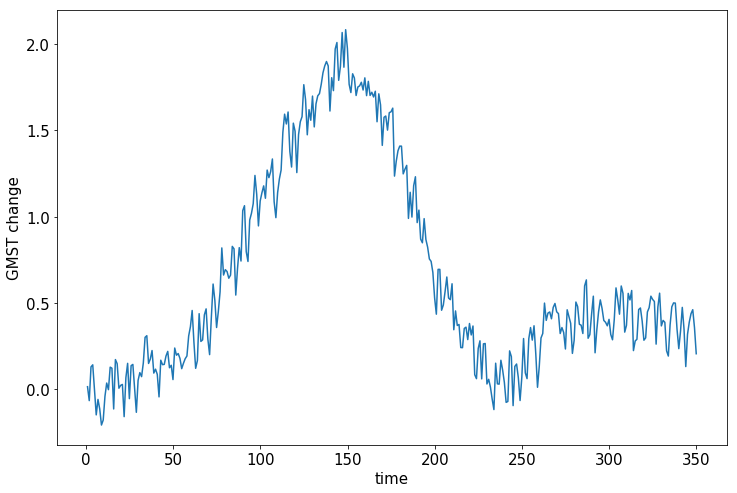

In [27]:
annual_gmst_difference = (gmst_annual - gmst_annual[0:20].mean(dim='time'))
annual_gmst_difference.attrs['long_name'] = 'GMST change'
annual_gmst_difference.plot()

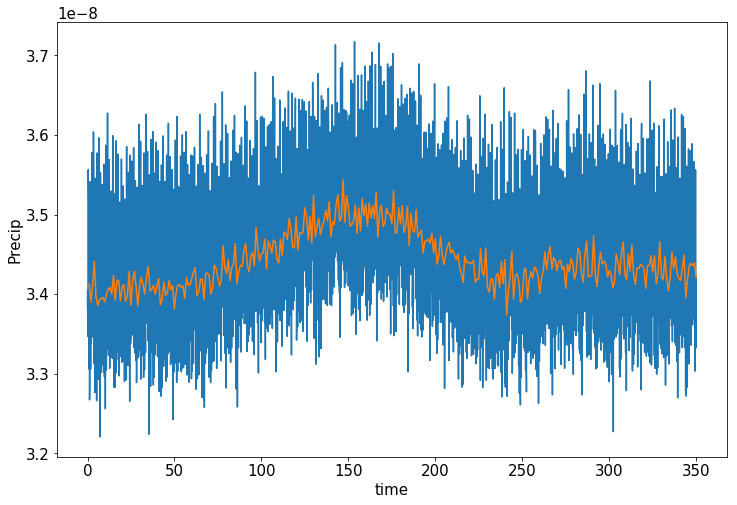

In [28]:
precip =  ((atm_in['PRECC'] + atm_in['PRECL']) * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
precip['time'] = np.arange(len(precip['time']))/12.
precip_annual = monthly_to_annual(precip)
precip_annual.attrs['long_name'] = 'Precip'
precip.attrs['long_name'] = 'Precip'
precip.plot()
precip_annual.plot()

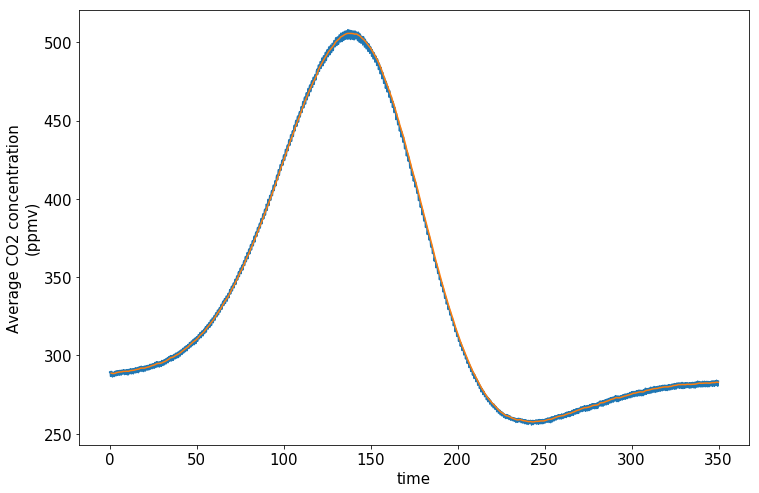

In [29]:
lnd_co2_ppmv = (lnd_in['PCO2']/lnd_in['PBOT']).mean(dim=('lat', 'lon')) * 1e6
lnd_co2_ppmv['time'] = np.arange(len(lnd_co2_ppmv['time']))/12.
lnd_co2_ppmv_annual = monthly_to_annual(lnd_co2_ppmv)
lnd_co2_ppmv.attrs['long_name'] = 'Average CO2 concentration (ppmv)'
lnd_co2_ppmv_annual.attrs['long_name'] = 'Average CO2 concentration (ppmv)'
lnd_co2_ppmv.plot()
lnd_co2_ppmv_annual.plot()

plt.savefig('co2_concentration.png', dpi=300, format='png')
plt.savefig('co2_concentration.pdf')

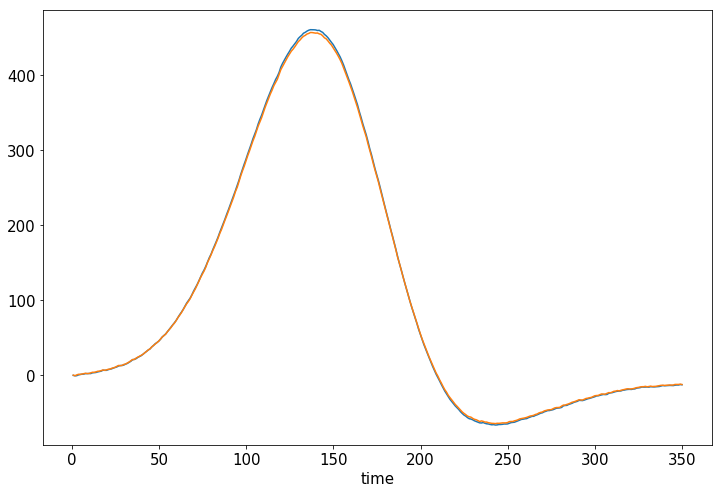

In [30]:
ppm_to_pgc = 2.124

atm_co2_pgc = ppm_to_pgc *(lnd_co2_ppmv_annual - lnd_co2_ppmv_annual[0])

atm_co2_pgc.plot()

((1e-15 * 12./44.)*sfco2_tot_annual).cumsum().plot()

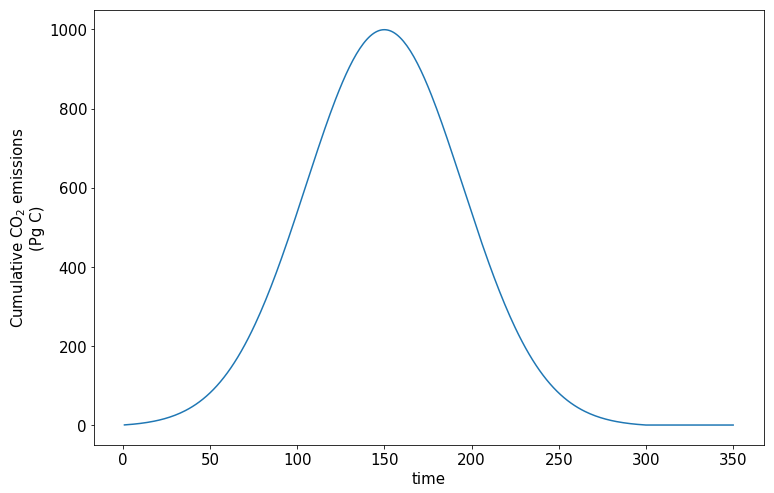

In [31]:
cumulative_emissions_pgc = ((1e-15*12./44.)*sfco2_fff_annual).cumsum()
cumulative_emissions_pgc.attrs['long_name'] = 'Cumulative CO$_2$ emissions (Pg C)'
cumulative_emissions_pgc.plot()

plt.savefig('cumulative_emiss_timeseries.png', dpi=300, format='png')
plt.savefig('cumulative_emiss_timeseries.pdf')

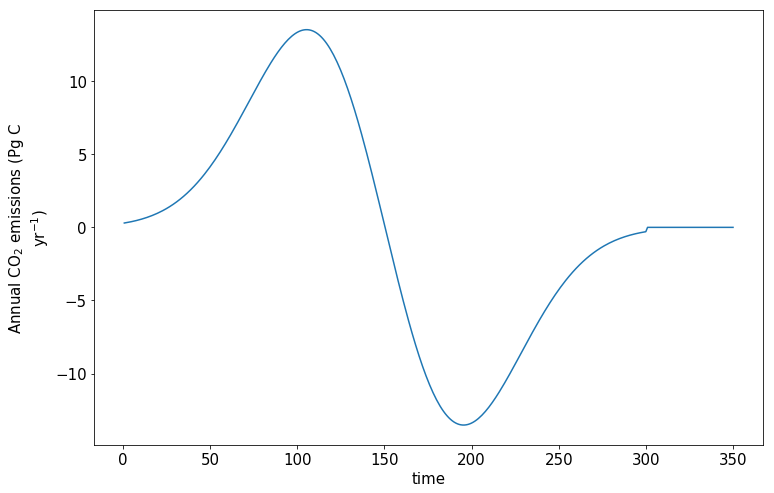

In [32]:
annual_emmissions_pgc = ((1e-15*12./44.)*sfco2_fff_annual)
annual_emmissions_pgc.attrs['long_name'] = 'Annual CO$_2$ emissions (Pg C yr$^{-1}$)'
annual_emmissions_pgc.plot()

plt.savefig('emiss_timeseries.png', dpi=300, format='png')
plt.savefig('emiss_timeseries.pdf')

TCRE =  2.079529412181452


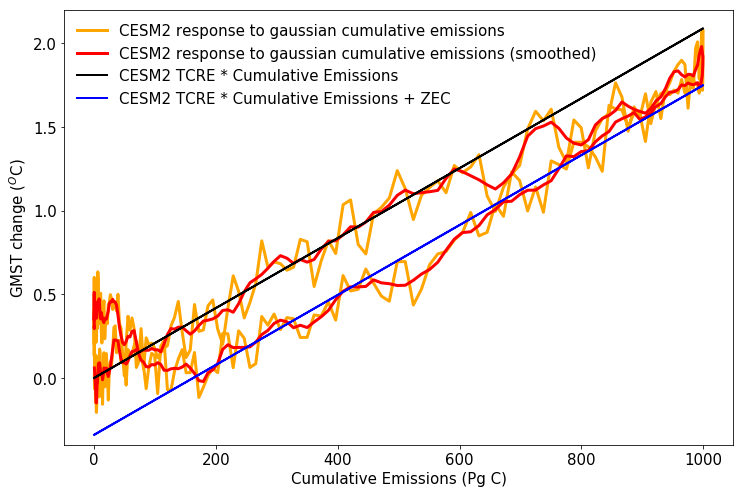

In [33]:
plt.plot(cumulative_emissions_pgc, annual_gmst_difference, color='Orange', label='CESM2 response to gaussian cumulative emissions', linewidth=3)

plt.plot(cumulative_emissions_pgc, savgol_filter(annual_gmst_difference, 11), color='Red', label='CESM2 response to gaussian cumulative emissions (smoothed)', linewidth=3)


m, b = np.polyfit(cumulative_emissions_pgc[0:int(annual_emmissions_pgc.argmax())], annual_gmst_difference[0:int(annual_emmissions_pgc.argmax())], 1)
#plt.plot(cumulative_emissions_pgc, m*cumulative_emissions_pgc + b)

tcre_arora = 2.09 * 1e-3
zec90_macdougall = -0.34

plt.plot(cumulative_emissions_pgc, tcre_arora*cumulative_emissions_pgc, color='Black', label='CESM2 TCRE * Cumulative Emissions', linewidth=2)
plt.plot(cumulative_emissions_pgc, tcre_arora*cumulative_emissions_pgc + zec90_macdougall, color='Blue', label='CESM2 TCRE * Cumulative Emissions + ZEC', linewidth=2)


plt.ylabel('GMST change ($^O$C)')
plt.xlabel('Cumulative Emissions (Pg C)')

plt.legend(frameon=False)

plt.ylim((-0.4,2.2))

print('TCRE = ', m * 1000.)

plt.savefig('temp_vs_ce.png', dpi=300, format='png')
plt.savefig('temp_vs_ce.pdf')

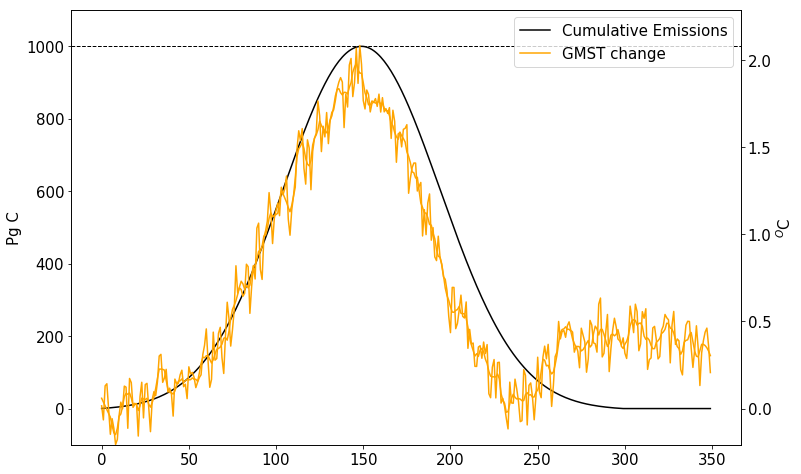

<Figure size 864x576 with 0 Axes>

In [34]:
ax1 = plt.subplot()
l1, = ax1.plot(cumulative_emissions_pgc, color='black')
ax2 = ax1.twinx()
l2, = ax2.plot(annual_gmst_difference, color='orange')

ax1.set_ylim((-100,1100))
ax1.set_ylabel('Pg C')

ax2.set_ylim((-100. * m, 1100. * m))
ax2.set_ylabel('$^O$C')

ax1.axhline(1000., color='black', linestyle='--', linewidth=1)

ax2.plot(savgol_filter(annual_gmst_difference, 11), color='orange')



plt.legend([l1, l2], ["Cumulative Emissions", "GMST change"])

plt.show()

plt.savefig('temp_ce_timeseries.png', dpi=300, format='png')
plt.savefig('temp_ce_timeseries.pdf')

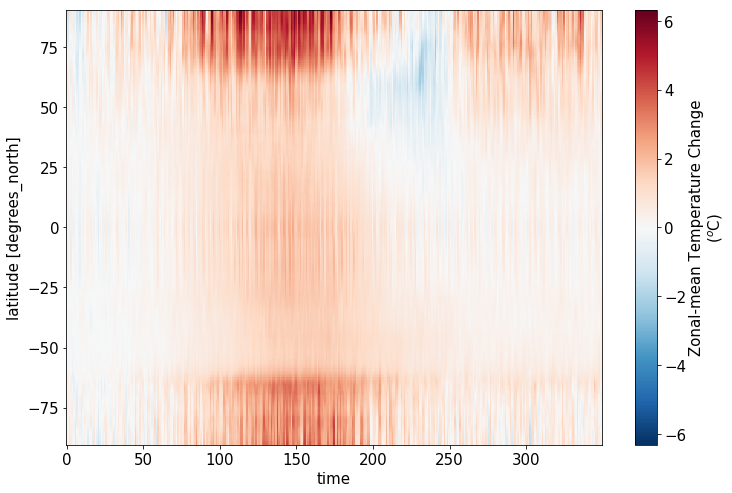

In [35]:
zonal_mean_temp = monthly_to_annual(atm_in['TREFHT'] - 273.15).mean(dim='lon')
zonal_mean_temp['time'] = np.arange(len(zonal_mean_temp['time']))
zonal_mean_temp_diff = zonal_mean_temp - zonal_mean_temp.isel(time=slice(0,20)).mean(dim='time')
zonal_mean_temp_diff.attrs['long_name'] = 'Zonal-mean Temperature Change ($^{o}$C)'

zonal_mean_temp_diff.plot(x='time',y='lat')

plt.savefig('temp_zonalmean.png', dpi=300, format='png')
plt.savefig('temp_zonalmean.pdf')

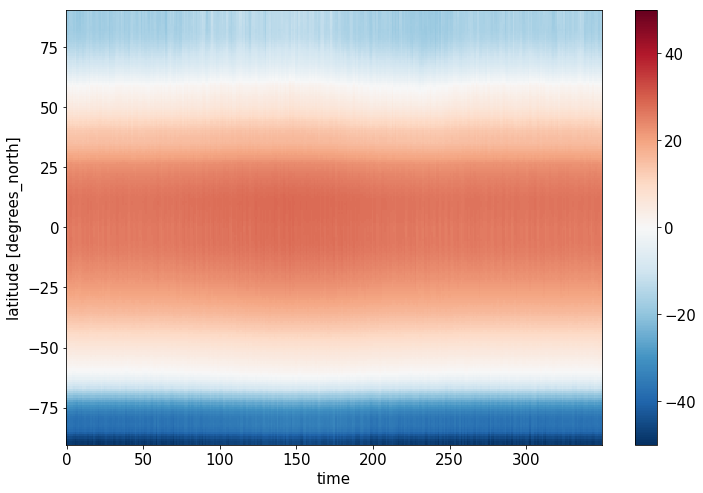

In [36]:
zonal_mean_temp.plot(x='time',y='lat')

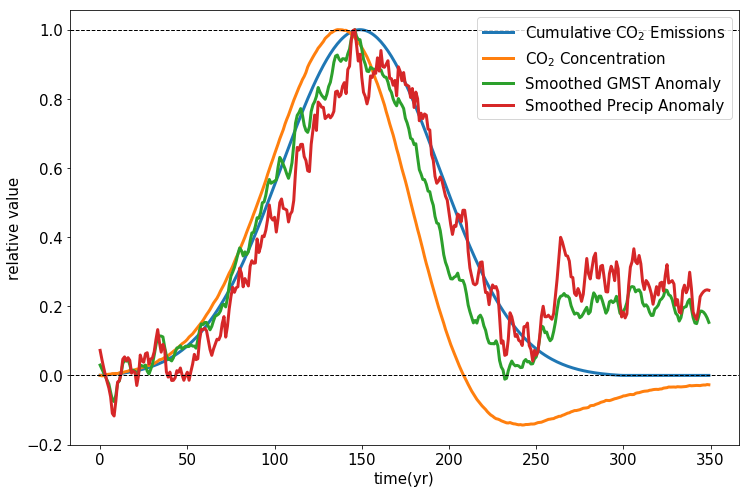

In [37]:

smoothing_window = 11

plt.plot(cumulative_emissions_pgc/cumulative_emissions_pgc.max(), label='Cumulative CO$_2$ Emissions', linewidth=3)
plt.plot(atm_co2_pgc/atm_co2_pgc.max(), label='CO$_2$ Concentration', linewidth=3)
plt.plot(savgol_filter(annual_gmst_difference, smoothing_window)/savgol_filter(annual_gmst_difference, smoothing_window).max(), label='Smoothed GMST Anomaly', linewidth=3)
plt.plot(savgol_filter((precip_annual - precip_annual.isel(time=slice(0,20)).mean(dim='time')), smoothing_window)/savgol_filter((precip_annual - precip_annual.isel(time=slice(0,20)).mean(dim='time')), smoothing_window).max(), label='Smoothed Precip Anomaly', linewidth=3)
plt.axhline(0., color='black', linestyle='--', linewidth=1)
plt.axhline(1., color='black', linestyle='--', linewidth=1)
plt.xlabel('time(yr)')
plt.ylabel('relative value')
plt.legend()


plt.savefig('temp_precip_ce_co2_timeseries.png', dpi=300, format='png')
plt.savefig('temp_precip_ce_co2_timeseries.pdf')

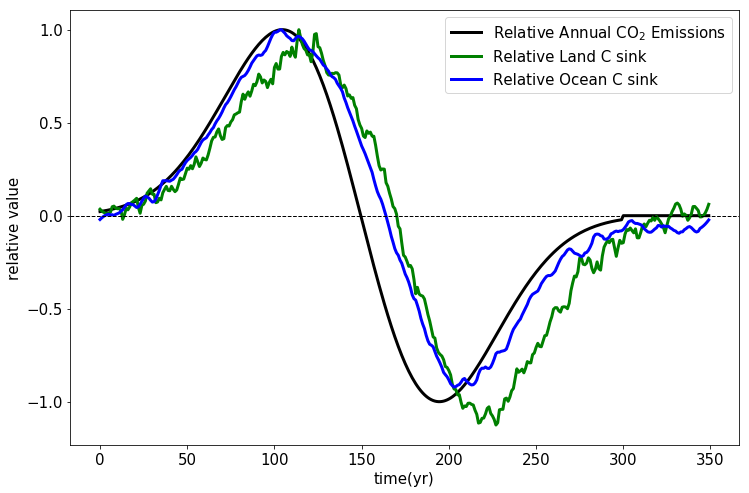

In [38]:

plt.plot(annual_emmissions_pgc/annual_emmissions_pgc.max(), label='Relative Annual CO$_2$ Emissions', linewidth=3, color='Black')
plt.plot(savgol_filter(-1. * sfco2_lnd_annual, smoothing_window)/savgol_filter(-1. * sfco2_lnd_annual, smoothing_window).max(), label = 'Relative Land C sink', linewidth=3, color='Green')
plt.plot(savgol_filter(-1. * sfco2_ocn_annual, smoothing_window)/savgol_filter(-1. * sfco2_ocn_annual, smoothing_window).max(), label = 'Relative Ocean C sink', linewidth=3, color='Blue')
plt.axhline(0., color='black', linestyle='--', linewidth=1)
plt.xlabel('time(yr)')
plt.ylabel('relative value')
plt.legend()


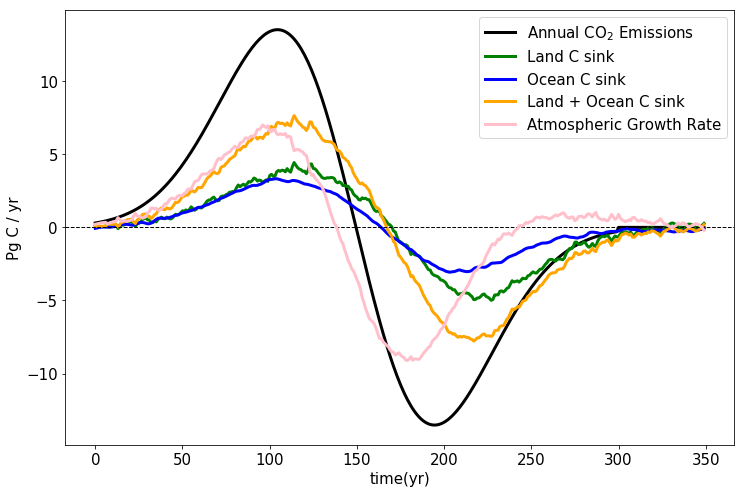

In [39]:

plt.plot(annual_emmissions_pgc, label='Annual CO$_2$ Emissions', linewidth=3, color='Black')
plt.plot(savgol_filter(12./44. * 1e-15 * -1. * sfco2_lnd_annual, smoothing_window), label = 'Land C sink', linewidth=3, color='Green')
plt.plot(savgol_filter(12./44. * 1e-15 * -1. * sfco2_ocn_annual, smoothing_window), label = 'Ocean C sink', linewidth=3, color='Blue')
plt.plot(savgol_filter(12./44. * 1e-15 * -1. * (sfco2_ocn_annual+sfco2_lnd_annual), smoothing_window), label = 'Land + Ocean C sink', linewidth=3, color='Orange')
plt.axhline(0., color='black', linestyle='--', linewidth=1)

atm_growth_rate = annual_emmissions_pgc - savgol_filter(12./44. * 1e-15 * -1. * (sfco2_ocn_annual+sfco2_lnd_annual), smoothing_window)
plt.plot(atm_growth_rate, label = 'Atmospheric Growth Rate', linewidth=3, color='Pink')

plt.xlabel('time(yr)')
plt.ylabel('Pg C / yr')
plt.legend()


plt.savefig('flux_timeseries.png', dpi=300, format='png')
plt.savefig('flux_timeseries.pdf')

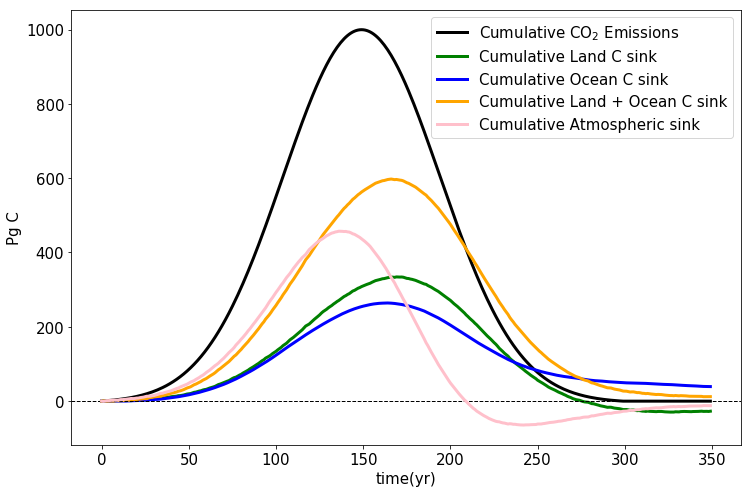

In [40]:

plt.plot(annual_emmissions_pgc.cumsum(), label='Cumulative CO$_2$ Emissions', linewidth=3, color='Black')
plt.plot(12./44. * 1e-15 * -1. * sfco2_lnd_annual.cumsum(), label = 'Cumulative Land C sink', linewidth=3, color='Green')
plt.plot(12./44. * 1e-15 * -1. * sfco2_ocn_annual.cumsum(), label = 'Cumulative Ocean C sink', linewidth=3, color='Blue')
plt.plot(12./44. * 1e-15 * -1. * (sfco2_ocn_annual+sfco2_lnd_annual).cumsum(), label = 'Cumulative Land + Ocean C sink', linewidth=3, color='Orange')
plt.axhline(0., color='black', linestyle='--', linewidth=1)

atm_growth_rate = annual_emmissions_pgc.cumsum() - (12./44. * 1e-15 * -1. * (sfco2_ocn_annual+sfco2_lnd_annual).cumsum())
plt.plot(atm_growth_rate, label = 'Cumulative Atmospheric sink', linewidth=3, color='Pink')

plt.xlabel('time(yr)')
plt.ylabel('Pg C')
plt.legend()

plt.savefig('cumulative_flux_timeseries.png', dpi=300, format='png')
plt.savefig('cumulative_flux_timeseries.pdf')

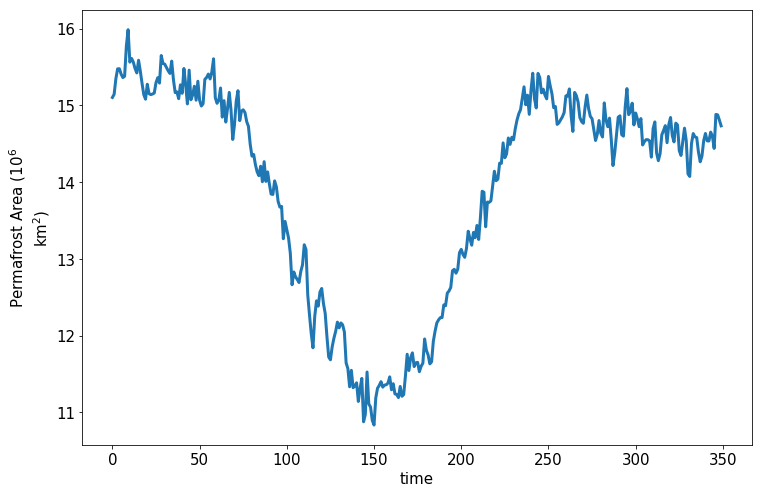

In [41]:
permafrost_area = 1e-12 *((lnd_in['ALTMAX'][::12,:,:] < 3.) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
#permafrost_area.shape
permafrost_area['time'] = np.arange(len(permafrost_area['time']))
permafrost_area.attrs['long_name'] = 'Permafrost Area (10$^6$ km$^2$)'
permafrost_area.plot(linewidth=3)

In [42]:
pf = lnd_in['ALTMAX'][0:240:12,:,:].mean(dim='time') < 3.
#pf.plot()

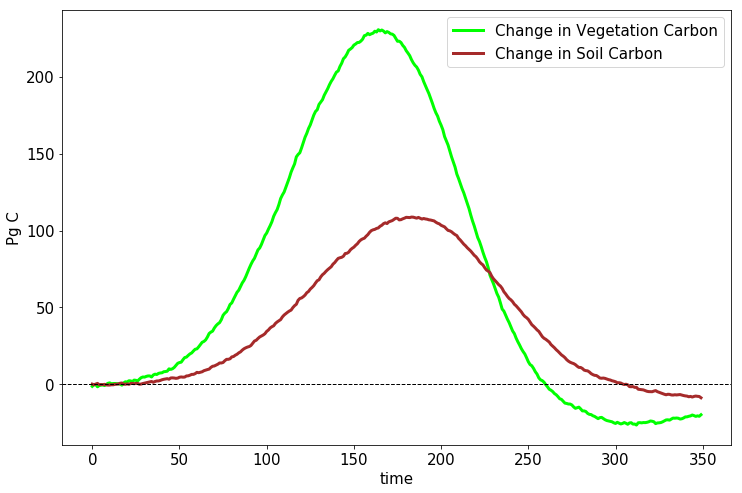

In [43]:
vegc = 1e-15 * (monthly_to_annual(lnd_in['TOTVEGC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
vegc['time'] = np.arange(len(vegc['time']))

totsomc = 1e-15 * (monthly_to_annual(lnd_in['TOTSOMC'] + lnd_in['TOTLITC'] + lnd_in['CWDC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
totsomc['time'] = np.arange(len(totsomc['time']))

pf_soilc = 1e-15 * (monthly_to_annual(lnd_in['TOTSOMC']) * pf * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
pf_soilc['time'] = np.arange(len(pf_soilc['time']))


(vegc - vegc.isel(time=slice(0,20)).mean(dim='time')).plot(label = 'Change in Vegetation Carbon', linewidth=3, color='Lime')
(totsomc - totsomc.isel(time=slice(0,20)).mean(dim='time')).plot(label = 'Change in Soil Carbon', linewidth=3, color='Brown')
#totsomc.plot()
#pf_soilc.plot()
plt.ylabel('Pg C')
plt.axhline(0., color='black', linestyle='--', linewidth=1)
plt.legend()


plt.savefig('vegc_soilc_timeseries.png', dpi=300, format='png')
plt.savefig('vegc_soilc_timeseries.pdf')

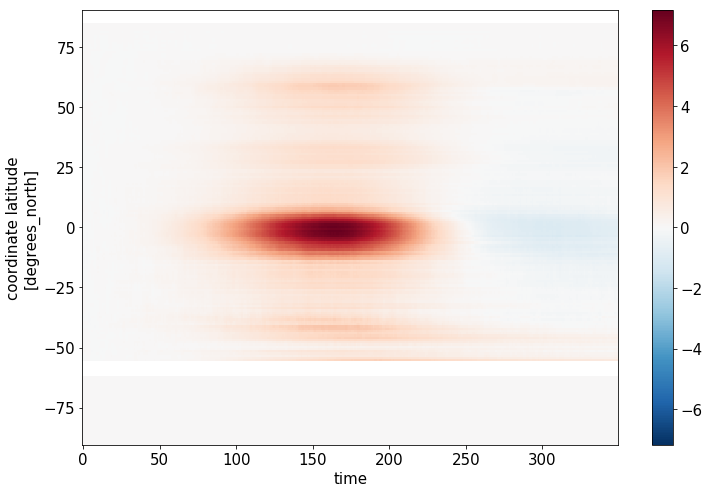

In [44]:
vegc_zonal = 1e-3 * (monthly_to_annual(lnd_in['TOTVEGC']).mean(dim='lon'))
vegc_zonal['time'] = np.arange(len(vegc['time']))

(vegc_zonal - vegc_zonal.isel(time=slice(0,20)).mean(dim='time')).plot(x='time',y='lat')


plt.savefig('vegc_zonalmean.png', dpi=300, format='png')
plt.savefig('vegc_zonalmean.pdf')

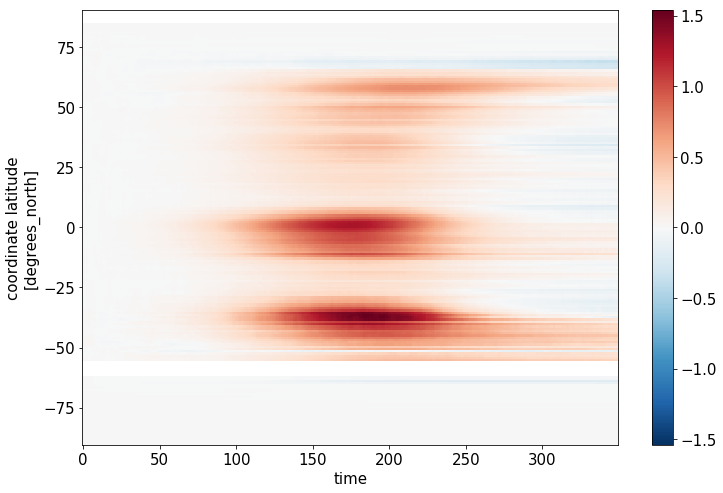

In [45]:
soilc_zonal = 1e-3 * (monthly_to_annual(lnd_in['TOTSOMC']).mean(dim='lon'))
soilc_zonal['time'] = np.arange(len(vegc['time']))

soilc_zonal.attrs['long_name'] = 'Zonal-mean Soil C Change (kg C m$^{-2}$)'

(soilc_zonal - soilc_zonal.isel(time=slice(0,20)).mean(dim='time')).plot(x='time',y='lat')


plt.savefig('soilc_zonalmean.png', dpi=300, format='png')
plt.savefig('soilc_zonalmean.pdf')

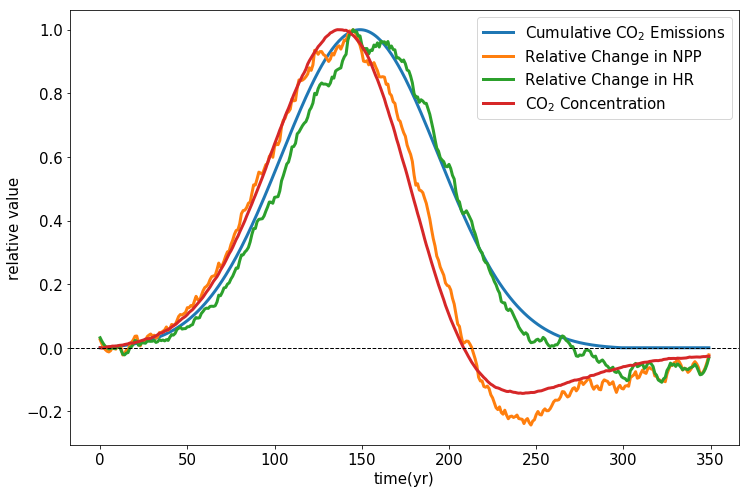

In [46]:
gpp = 1e-15 * 86400. * 365. * (monthly_to_annual(lnd_in['GPP']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
gpp['time'] = np.arange(len(gpp['time']))

npp = 1e-15 * 86400. * 365. * (monthly_to_annual(lnd_in['NPP']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
npp['time'] = np.arange(len(npp['time']))

hr = 1e-15 * 86400. * 365. * (monthly_to_annual(lnd_in['HR']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
hr['time'] = np.arange(len(hr['time']))

burnflux = 1e-15 * 86400. * 365. * (monthly_to_annual(lnd_in['COL_FIRE_CLOSS']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
burnflux['time'] = np.arange(len(burnflux['time']))


gpp_anom = savgol_filter(gpp - gpp.isel(time=slice(0,20)).mean(dim='time'), smoothing_window)
npp_anom = savgol_filter(npp - npp.isel(time=slice(0,20)).mean(dim='time'), smoothing_window)
hr_anom = savgol_filter(hr - hr.isel(time=slice(0,20)).mean(dim='time'), smoothing_window)


plt.plot(cumulative_emissions_pgc/cumulative_emissions_pgc.max(), label='Cumulative CO$_2$ Emissions', linewidth=3)

#(gpp_anom/gpp_anom.max()).plot(label='Relative Change in GPP', linewidth=3)
(npp_anom/npp_anom.max()).plot(label='Relative Change in NPP', linewidth=3)
(hr_anom/hr_anom.max()).plot(label='Relative Change in HR', linewidth=3)
plt.plot(atm_co2_pgc/atm_co2_pgc.max(), label='CO$_2$ Concentration', linewidth=3)

plt.axhline(0., color='black', linestyle='--', linewidth=1)

plt.xlabel('time(yr)')
plt.ylabel('relative value')
plt.legend()

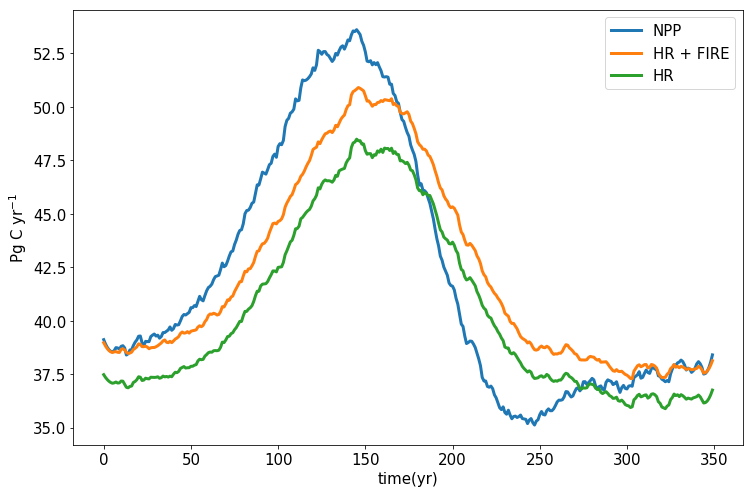

In [47]:

#plt.plot(cumulative_emissions_pgc/cumulative_emissions_pgc.max(), label='Cumulative CO$_2$ Emissions', linewidth=3)

#(gpp_anom/gpp_anom.max()).plot(label='Relative Change in GPP', linewidth=3)
savgol_filter(npp, smoothing_window).plot(label='NPP', linewidth=3)
#npp_smooth = npp.copy()
#npp_smooth[:] = scipy.signal.savgol_filter(npp, smoothing_window, 2)
#npp_smooth.plot(label='NPP smooth', linewidth=1)
savgol_filter(hr+burnflux, smoothing_window).plot(label='HR + FIRE', linewidth=3)
savgol_filter(hr, smoothing_window).plot(label='HR', linewidth=3)
#plt.plot(atm_co2_pgc/atm_co2_pgc.max(), label='CO$_2$ Concentration', linewidth=3)


plt.xlabel('time(yr)')
plt.ylabel('Pg C yr$^{-1}$')
plt.legend()

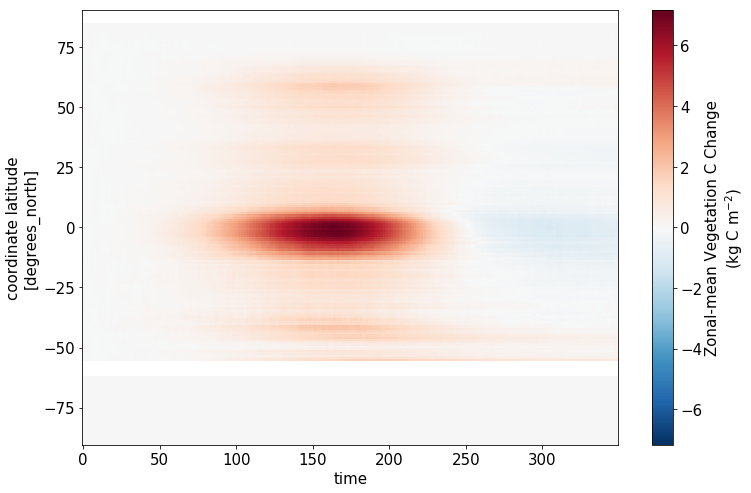

In [48]:
landonlymask = sftlf['sftlf']/sftlf['sftlf']

zonal_mean_totvegc = monthly_to_annual(lnd_in['TOTVEGC']).mean(dim='lon') * 1e-3
zonal_mean_totvegc['time'] = np.arange(len(zonal_mean_totvegc['time']))
zonal_mean_totvegc_diff = zonal_mean_totvegc - zonal_mean_totvegc.isel(time=slice(0,20)).mean(dim='time')
zonal_mean_totvegc_diff.attrs['long_name'] = 'Zonal-mean Vegetation C Change (kg C m$^{-2}$)'
zonal_mean_totvegc_diff.plot(x='time',y='lat')

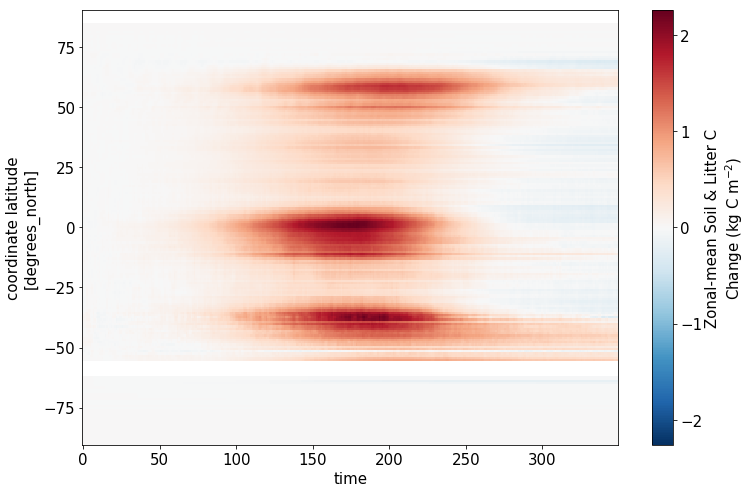

In [49]:
zonal_mean_totsomc = monthly_to_annual(lnd_in['TOTSOMC'] + lnd_in['TOTLITC'] + lnd_in['CWDC']).mean(dim='lon') * 1e-3
zonal_mean_totsomc['time'] = np.arange(len(zonal_mean_totvegc['time']))
zonal_mean_totsomc_diff = zonal_mean_totsomc - zonal_mean_totsomc.isel(time=slice(0,20)).mean(dim='time')
zonal_mean_totsomc_diff.attrs['long_name'] = 'Zonal-mean Soil & Litter C Change (kg C m$^{-2}$)'
zonal_mean_totsomc_diff.plot(x='time',y='lat')

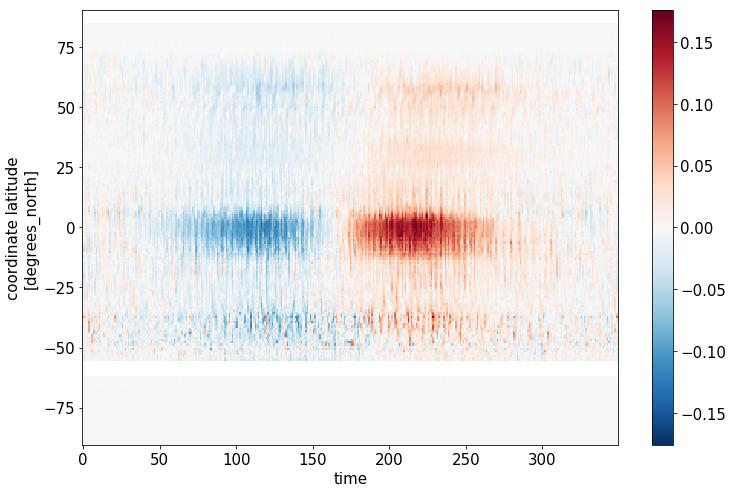

In [50]:
zonal_mean_nee = monthly_to_annual(lnd_in['NEE']).mean(dim='lon') * 1e-3 * 86400. * 365.
zonal_mean_nee['time'] = np.arange(len(zonal_mean_totvegc['time']))
zonal_mean_nee_diff = zonal_mean_nee - zonal_mean_nee.isel(time=slice(0,20)).mean(dim='time')
zonal_mean_nee_diff.plot(x='time',y='lat')

In [51]:
int(annual_emmissions_pgc.argmax())

104

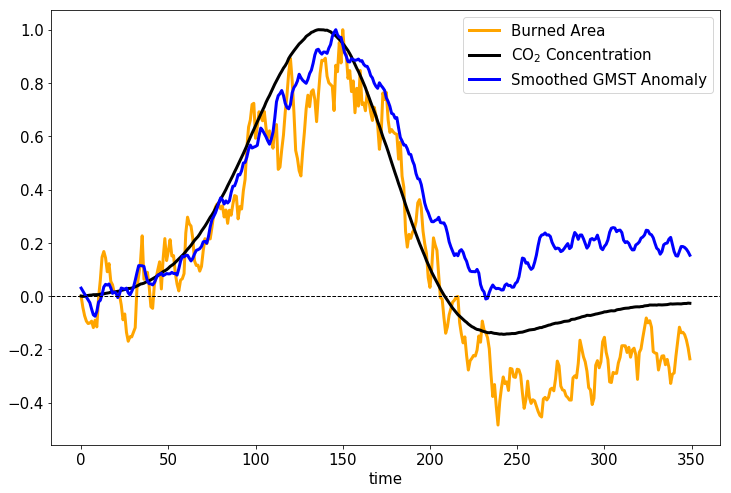

In [52]:


burnedarea = 86400. * 365. * (monthly_to_annual(lnd_in['FAREA_BURNED']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
burnedarea['time'] = np.arange(len(burnedarea['time']))

burnedarea_smooth = savgol_filter(burnedarea, smoothing_window)
#burnedarea.plot()
((burnedarea_smooth - burnedarea_smooth.isel(time=slice(0,20)).mean())/(burnedarea_smooth - burnedarea_smooth.isel(time=slice(0,20)).mean()).max()).plot(label='Burned Area', linewidth=3, color='Orange')

plt.plot(atm_co2_pgc/atm_co2_pgc.max(), label='CO$_2$ Concentration', linewidth=3, color='Black')
plt.plot(savgol_filter(annual_gmst_difference, smoothing_window)/savgol_filter(annual_gmst_difference, smoothing_window).max(), label='Smoothed GMST Anomaly', linewidth=3, color='Blue')


plt.axhline(0., color='black', linestyle='--', linewidth=1)
plt.legend()



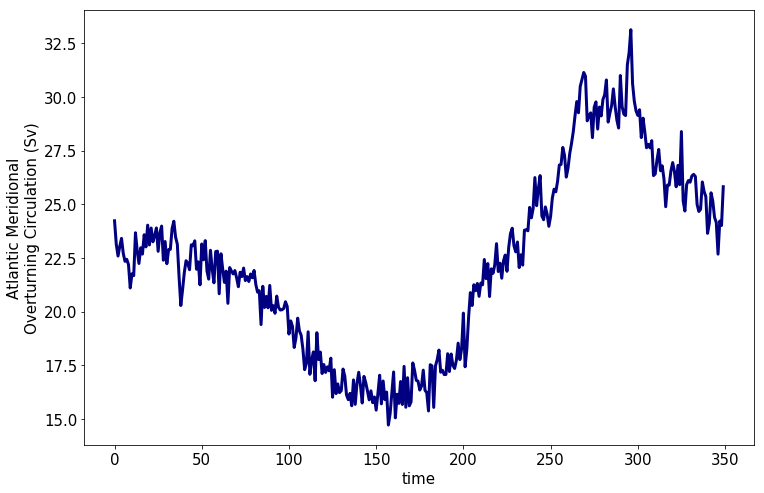

In [53]:
amoc_annual = monthly_to_annual(ocn_in['MOC'].isel(transport_reg=1).sum(dim='moc_comp')).max(dim='moc_z').max(dim='lat_aux_grid')
amoc_annual['time'] = np.arange(len(amoc_annual['time']))
amoc_annual.attrs['long_name'] = 'Atlantic Meridional Overturning Circulation (Sv)'
amoc_annual.plot(linewidth=3, color='Navy')


plt.savefig('amoc_timeseries.png', dpi=300, format='png')
plt.savefig('amoc_timeseries.pdf')

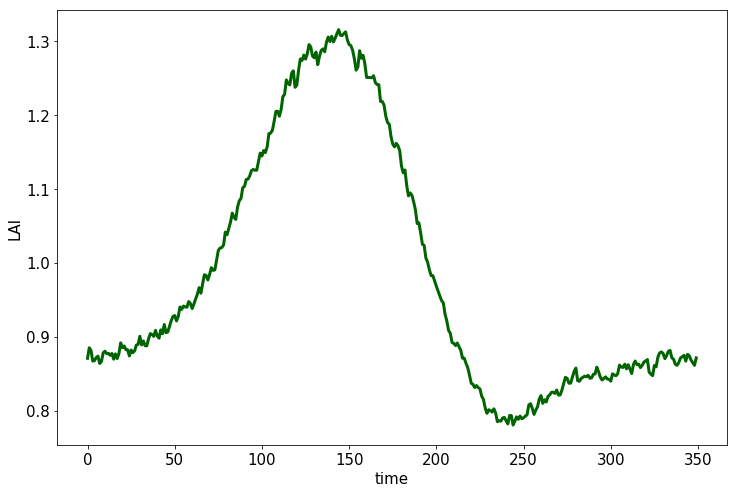

In [54]:
annual_mean_lai = monthly_to_annual(lnd_in['TLAI']).mean(dim=('lat','lon'))
annual_mean_lai['time'] = np.arange(len(annual_mean_lai['time']))
annual_mean_lai.attrs['long_name'] = 'LAI'

annual_mean_lai.plot(linewidth=3, color='darkgreen')


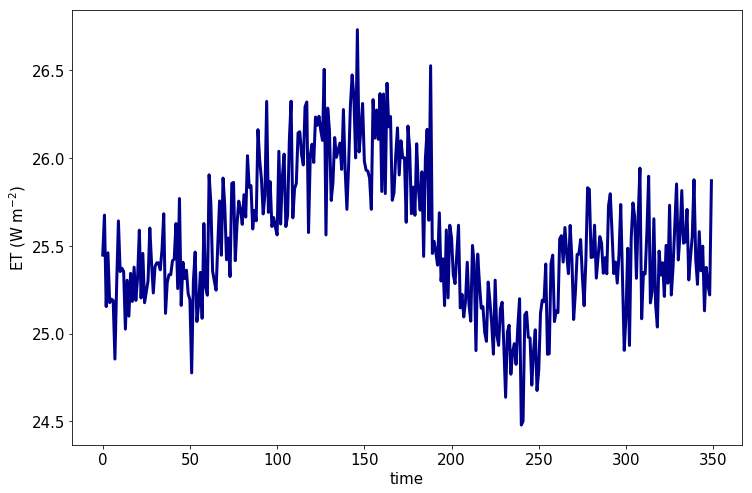

In [55]:
annual_mean_ET = monthly_to_annual(lnd_in['EFLX_LH_TOT']).mean(dim=('lat','lon'))
annual_mean_ET['time'] = np.arange(len(annual_mean_ET['time']))
annual_mean_ET.attrs['long_name'] = 'ET (W m$^{-2}$)'

annual_mean_ET.plot(linewidth=3, color='darkblue')


plt.savefig('et_timeseries.png', dpi=300, format='png')
plt.savefig('et_timeseries.pdf')

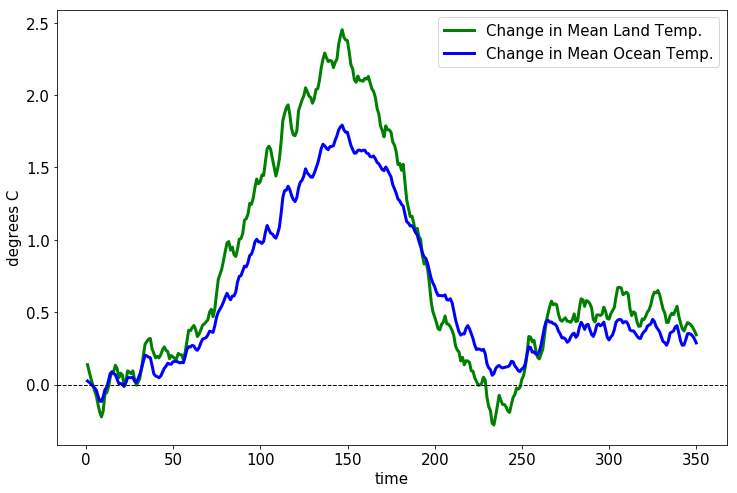

In [56]:
landonlymask = sftlf['sftlf']/sftlf['sftlf']
oceanonlymask = (100.- sftlf['sftlf'])/(100.- sftlf['sftlf'])
land_temp =  -273.15 +(atm_in['TREFHT'] * landonlymask * areacella['areacella'].data).sum(dim=('lat', 'lon')) / (landonlymask * areacella['areacella']).sum(dim=('lat', 'lon'))
land_temp['time'] = np.arange(len(land_temp['time']))/12.
land_temp_annual = monthly_to_annual(land_temp)
land_temp_annual_anom = land_temp_annual - land_temp_annual.isel(time=slice(0,20)).mean()
savgol_filter(land_temp_annual_anom, smoothing_window).plot(linewidth=3, color='Green', label='Change in Mean Land Temp.')

ocean_temp =  -273.15 +(atm_in['TREFHT'] * oceanonlymask * areacella['areacella'].data).sum(dim=('lat', 'lon')) / (oceanonlymask * areacella['areacella']).sum(dim=('lat', 'lon'))
ocean_temp['time'] = np.arange(len(ocean_temp['time']))/12.
ocean_temp_annual = monthly_to_annual(ocean_temp)
ocean_temp_annual_anom = ocean_temp_annual - ocean_temp_annual.isel(time=slice(0,20)).mean()
savgol_filter(ocean_temp_annual_anom, smoothing_window).plot(linewidth=3, color='Blue', label='Change in Mean Ocean Temp.')

plt.ylabel('degrees C')
plt.axhline(0., color='black', linestyle='--', linewidth=1)
plt.legend()


plt.savefig('landocean_precip_temp.png', dpi=300, format='png')
plt.savefig('landocean_precip_temp.pdf')

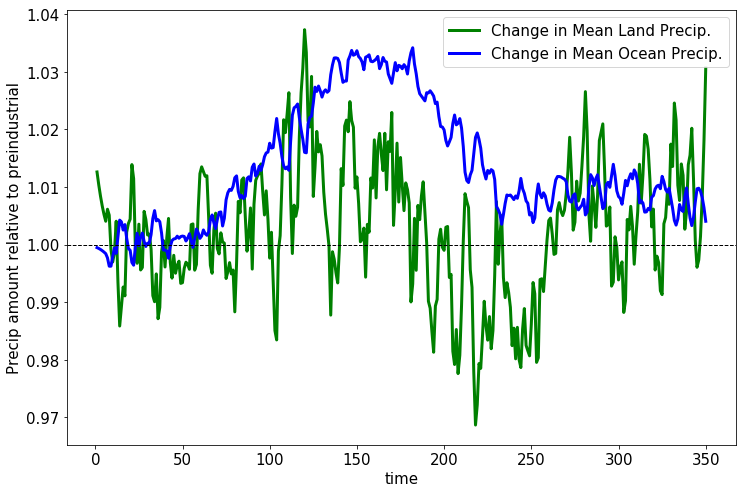

In [57]:

land_precip =  ((atm_in['PRECC']+atm_in['PRECL']) * landonlymask * areacella['areacella'].data).sum(dim=('lat', 'lon')) / (landonlymask * areacella['areacella']).sum(dim=('lat', 'lon'))
land_precip['time'] = np.arange(len(land_precip['time']))/12.
land_precip_annual = monthly_to_annual(land_precip)
land_precip_annual_anom = land_precip_annual / land_precip_annual.isel(time=slice(0,20)).mean()
savgol_filter(land_precip_annual_anom, smoothing_window).plot(linewidth=3, color='Green', label='Change in Mean Land Precip.')

ocean_precip =  ((atm_in['PRECC']+atm_in['PRECL']) * oceanonlymask * areacella['areacella'].data).sum(dim=('lat', 'lon')) / (oceanonlymask * areacella['areacella']).sum(dim=('lat', 'lon'))
ocean_precip['time'] = np.arange(len(ocean_precip['time']))/12.
ocean_precip_annual = monthly_to_annual(ocean_precip)
ocean_precip_annual_anom = ocean_precip_annual / ocean_precip_annual.isel(time=slice(0,20)).mean()
savgol_filter(ocean_precip_annual_anom, smoothing_window).plot(linewidth=3, color='Blue', label='Change in Mean Ocean Precip.')

plt.ylabel('Precip amount relative to preindustrial')
plt.axhline(1., color='black', linestyle='--', linewidth=1)
plt.legend()


#plt.savefig('landocean_precip_precip.png', dpi=300, format='png')
#plt.savefig('landocean_precip_precip.pdf')

In [58]:
autocorr_emissions = np.correlate(annual_emmissions_pgc - annual_emmissions_pgc.mean(), annual_emmissions_pgc - annual_emmissions_pgc.mean(), mode='full')

landsink = 12./44. * 1e-15 * -1. * sfco2_lnd_annual
corr_emissions_landsink = np.correlate(annual_emmissions_pgc - annual_emmissions_pgc.mean(), landsink-landsink.mean(), mode='full')
lag_emissions_landsink = autocorr_emissions.argmax() -corr_emissions_landsink.argmax()
print('lag_emissions_landsink',lag_emissions_landsink)

oceansink = 12./44. * 1e-15 * -1. * sfco2_ocn_annual
corr_emissions_oceansink = np.correlate(annual_emmissions_pgc - annual_emmissions_pgc.mean(), oceansink-oceansink.mean(), mode='full')
lag_emissions_oceansink = autocorr_emissions.argmax() - corr_emissions_oceansink.argmax()
print('lag_emissions_oceansink',lag_emissions_oceansink)

atmgrowthrate = annual_emmissions_pgc - landsink - oceansink
corr_emissions_atmgrowth = np.correlate(annual_emmissions_pgc - annual_emmissions_pgc.mean(), atmgrowthrate-atmgrowthrate.mean(), mode='full')
lag_emissions_atmgrowth = autocorr_emissions.argmax() - corr_emissions_atmgrowth.argmax()
print('lag_emissions_atmgrowth', lag_emissions_atmgrowth)

corr_cumemissions_cumatmgrowth = np.correlate(annual_emmissions_pgc.cumsum() - annual_emmissions_pgc.cumsum().mean(), atmgrowthrate.cumsum()-atmgrowthrate.cumsum().mean(), mode='full')
lag_emissions_cumatmgrowth = autocorr_emissions.argmax() - corr_cumemissions_cumatmgrowth.argmax()
print('lag_emissions_cumatmgrowth', lag_emissions_cumatmgrowth)

lag_emissions_landsink 20
lag_emissions_oceansink 11
lag_emissions_atmgrowth -13
lag_emissions_cumatmgrowth -14


In [59]:
corr_cumatmgrowth_gmst = np.correlate(atmgrowthrate.cumsum()-atmgrowthrate.cumsum().mean(), gmst_annual - gmst_annual.mean(), mode='full')
lag_cumatmgrowth_gmst = autocorr_emissions.argmax() - corr_cumatmgrowth_gmst.argmax()
print('lag_cumatmgrowth_gmst',lag_cumatmgrowth_gmst)

corr_cumemissions_gmst = np.correlate(annual_emmissions_pgc.cumsum()-annual_emmissions_pgc.cumsum().mean(), gmst_annual - gmst_annual.mean(), mode='full')
lag_cumemissions_gmst = autocorr_emissions.argmax() - corr_cumemissions_gmst.argmax()
print('lag_cumemissions_gmst',lag_cumemissions_gmst)

lag_cumatmgrowth_gmst 5
lag_cumemissions_gmst -4


329

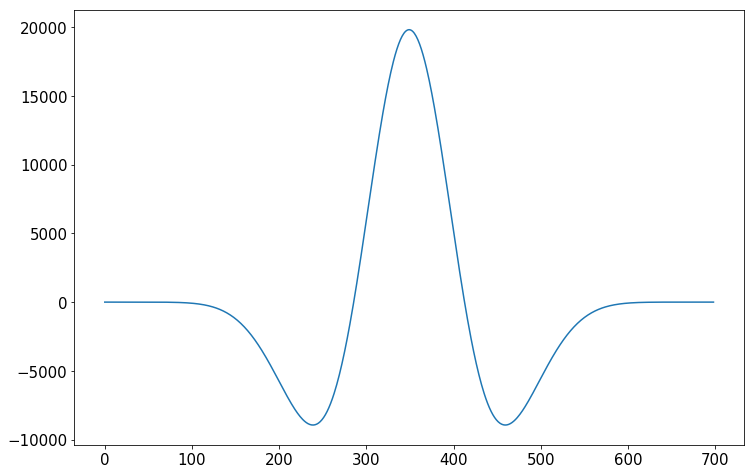

In [60]:
#plt.plot(corr_emissions_landsink)
plt.plot(autocorr_emissions)
autocorr_emissions.argmax()
np.abs(corr_emissions_landsink).argmax()



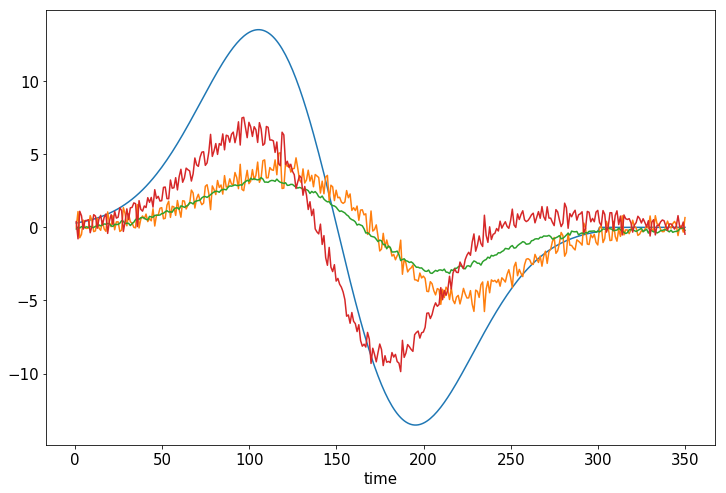

In [61]:
annual_emmissions_pgc.plot()
landsink.plot()
oceansink.plot()
atmgrowthrate.plot()

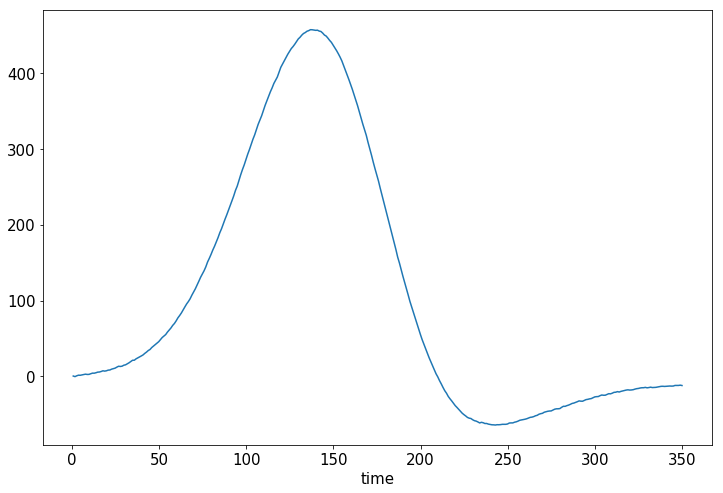

In [62]:
atmgrowthrate.cumsum().plot()

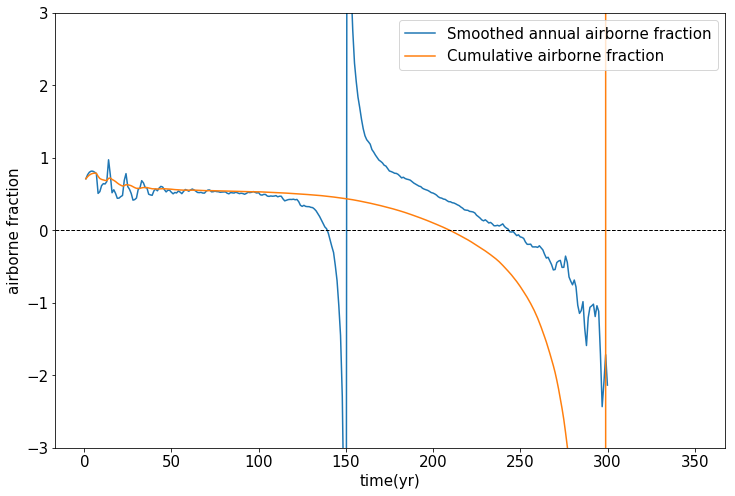

In [63]:
atm_growth_rate = annual_emmissions_pgc - savgol_filter(12./44. * 1e-15 * -1. * (sfco2_ocn_annual+sfco2_lnd_annual), smoothing_window)
airborne_fraction_instantaneous_smoothed = atm_growth_rate / annual_emmissions_pgc

airborne_fraction_instantaneous_smoothed.plot(label='Smoothed annual airborne fraction')

airborne_fraction_cumulative = atm_growth_rate.cumsum() / annual_emmissions_pgc.cumsum()
airborne_fraction_cumulative.plot(label='Cumulative airborne fraction')


plt.ylim((-3,3))

plt.xlabel('time(yr)')
plt.ylabel('airborne fraction')

plt.axhline(0., color='black', linestyle='--', linewidth=1)

plt.legend()

In [64]:
#finocn = xr.open_mfdataset(datadir+'/ocn/hist/cesm_edriven_idealizedcdr_feb2022_v3.pop.h.0190*.nc', decode_times=False)


In [65]:
#finocn_slice = xr.open_mfdataset(datadir+'/ocn/hist/cesm_edriven_idealizedcdr_feb2022_v3.pop.h.0[0-9][0-9]0-01.nc', decode_times=False)
finocn_slice = xr.open_mfdataset(datadir+'/ocn/hist/cesm_edriven_idealizedcdr_feb2022_v3.pop.DIC.annual.nc', decode_times=False)



In [66]:
#dicvtime = monthly_to_annual((finocn_slice['DIC']) * areacello['areacello'].data).sum(dim=('nlat', 'nlon')) * 12.e-3 *1e-15  

nskip=1
dicvtime = ((finocn_slice['DIC'][::nskip,:,:,:]) * areacello['areacello'].data).sum(dim=('nlat', 'nlon')) * 12.e-3 *1e-15  
dicvtime.attrs['long_name'] = 'DIC (Pg C / m)'



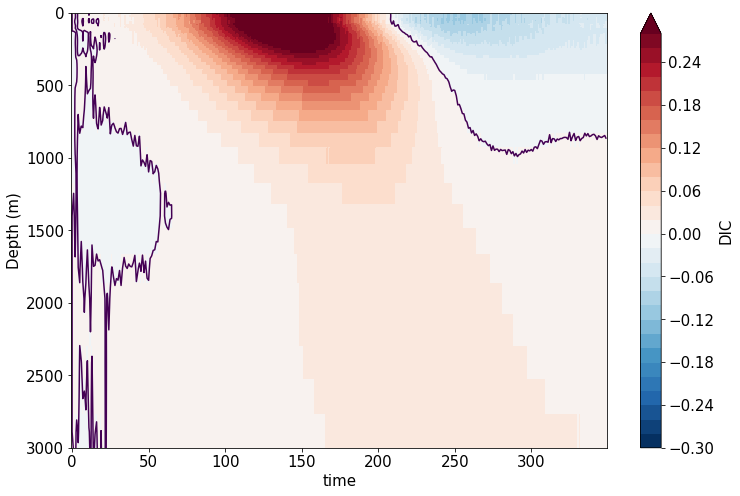

In [67]:
dicvtime['time'] = np.arange(len(dicvtime['time'])) * nskip
dicvtime['z_t'] = finocn_slice['z_t']/100.
dicvtime['z_t'].attrs['long_name'] = 'Depth (m)'

(dicvtime-dicvtime.isel(time=0)).plot(x='time',y='z_t',levels=np.arange(30)/30. * 0.6 - 0.3)
ax = plt.gca()
ax.set_ylim((3000.,0.))
plt.contour(dicvtime['time'][:], dicvtime['z_t'][:], (dicvtime-dicvtime.isel(time=0))[:].transpose(), levels=[0.])

#ax.set_yscale('log')


plt.savefig('dic_timedepth.png', dpi=300, format='png')
plt.savefig('dic_timedepth.pdf')

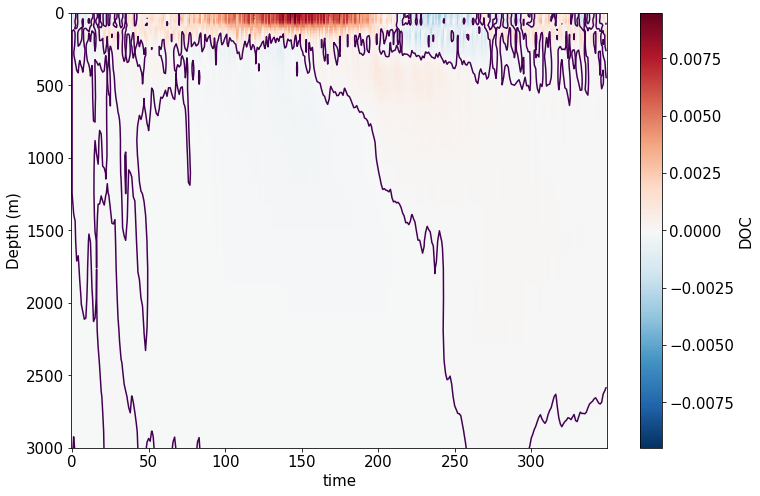

In [68]:
finocnDOC_slice = xr.open_mfdataset(datadir+'/ocn/hist/cesm_edriven_idealizedcdr_feb2022_v3.pop.DOC.annual.nc', decode_times=False)

#dicvtime = monthly_to_annual((finocn_slice['DIC']) * areacello['areacello'].data).sum(dim=('nlat', 'nlon')) * 12.e-3 *1e-15  

docvtime = ((finocnDOC_slice['DOC'][::nskip,:,:,:]) * areacello['areacello'].data).sum(dim=('nlat', 'nlon')) * 12.e-3 *1e-15  
docvtime.attrs['long_name'] = 'DOC (Pg C / m)'

docvtime['time'] = np.arange(len(docvtime['time'])) * nskip
docvtime['z_t'] = finocnDOC_slice['z_t']/100.
docvtime['z_t'].attrs['long_name'] = 'Depth (m)'

(docvtime-docvtime.isel(time=0)).plot(x='time',y='z_t')
ax = plt.gca()
ax.set_ylim((3000.,0.))
plt.contour(docvtime['time'][:], docvtime['z_t'][:], (docvtime-docvtime.isel(time=0))[:].transpose(), levels=[0.])

#ax.set_yscale('log')



In [69]:
np.arange(30)/30. * 0.6 - 0.3

array([-0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16, -0.14,
       -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,
        0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,  0.22,
        0.24,  0.26,  0.28])

In [70]:
ax.get_ylim()[::-1]

(0.0, 3000.0)

In [71]:
finocn_slice['DIC']

<xarray.DataArray 'DIC' (time: 350, z_t: 60, nlat: 384, nlon: 320)>
dask.array<shape=(350, 60, 384, 320), dtype=float32, chunksize=(350, 60, 384, 320)>
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<shape=(384, 320), chunksize=(384, 320)>
    TLONG    (nlat, nlon) float64 dask.array<shape=(384, 320), chunksize=(384, 320)>
  * time     (time) float64 396.0 761.0 1.126e+03 ... 1.274e+05 1.278e+05
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Dissolved Inorganic Carbon
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

In [72]:
finocn_slice

<xarray.Dataset>
Dimensions:       (d2: 2, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 350, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
    TLAT          (nlat, nlon) float64 dask.array<shape=(384, 320), chunksize=(384, 320)>
    TLONG         (nlat, nlon) float64 dask.array<shape=(384, 320), chunksize=(384, 320)>
  * lat_aux_grid  (lat_aux_grid) float32 -79.48815 -78.952896 ... 89.47441 90.0
  * moc_z         (moc_z) float32 0.0 1000.0 2000.0 ... 525000.94 549999.06
  * time          (time) float64 396.0 761.0 1.126e+03 ... 1.274e+05 1.278e+05
  * z_t           (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m      (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * z_w           (z_w) float32 0.0 1000.0 2000.0 ... 500004.7 525000.94
  * z_w_bot       (z_w_bot) float32 1000.0 2000.0 3000.0 ... 525000.94 549999.06
  * z_w_top       (z_w_top) float32 0.0 1000.0 2000.0 ... 500004.7 525000.94
Dimensions without coordin